In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
trees = pd.read_csv('data/black_spruce.csv')

In [3]:
trees['status_0_1'] = 0 + (trees['status'] == 'fallen')

In [4]:
splits=[4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 25, 32]
tree_bins = (trees['status_0_1']
 .groupby(pd.cut(trees['diameter'], splits))
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'proportion'})
 .assign(diameter=lambda df: [i.right for i in df.index])
)

In [5]:
from sklearn.linear_model import LogisticRegression

trees['log_diam'] = np.log(trees['diameter']) 
X = trees[['log_diam']].to_numpy()
y = trees['status_0_1'].to_numpy()

lr_model = LogisticRegression()
lr_model.fit(X, y)

LogisticRegression()

# From Probabilities to Classification

We started this chapter by presenting a binary classification problem where we want to model a nominal response variable. At this point, we have used logistic regression to model proportions or probabilities, and we're now ready to return to the original problem: we use the predicted probabilities to classify records. For our example, this means that for a tree of a particular diameter, we use the fitted coefficients from the logistic regression to estimate the chance it is fallen. If the chance is high, we classify a tree as fallen and otherwise we classify it as standing. But, we need to choose a threshold for making this *decision rule*.

The `sklearn` logistic regression model's `predict` function implements the basic decision rule: predict `1` if the predicted probability $ p > 0.5 $. Otherwise, predict 0. We've overlain this decision rule on top of the model predictions below as a dotted line:

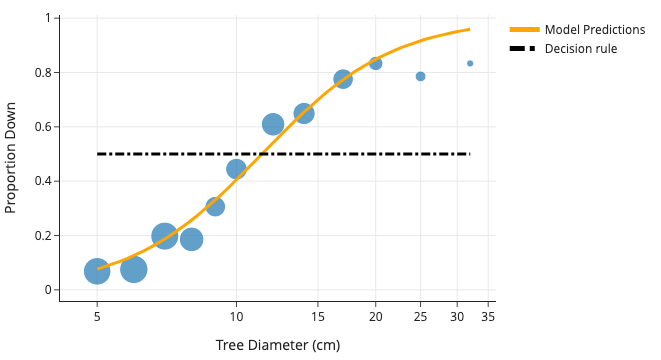

In [6]:
X_plt = np.expand_dims(np.linspace(X.min(), X.max(), 50) ,1)
p_hats = lr_model.predict_proba(X_plt)
X_orig = np.exp(X_plt)

fig = px.scatter(tree_bins, x='diameter', y='proportion', size='count',
                 log_x=True,
                 labels={'diameter':"Tree Diameter (cm)",
                         'proportion':"Proportion Down"},
                 width=550, height=250)

fig.add_trace(go.Scatter(x=X_orig[:, 0], y=p_hats[:, 1],
                         line=dict(color="orange", width=3),
                         mode='lines',
                         name='Model Predictions'))

fig.add_trace(go.Scatter(x=X_orig[:, 0], y=np.repeat(0.5, len(X_orig)),
                         line=dict(color="black", width=3, dash='dashdot'),
                         name='Decision rule'))

fig

In this section, we consider a more general decision rule. For some choice of $\tau$, predict 1 if the model's predicted probability $ p > \tau $, otherwise predict 0. By default, `sklearn` sets $ \tau = 0.5 $. Let's explore what happens when $ \tau $ is set to other values.

Choosing an appropriate value for $\tau$ depends on our goals. Suppose we want to maximize accuracy. The *accuracy* of a classifier is the fraction of correct predictions. We can compute the accuracy for different thresholds, meaning different $ \tau $ values:

In [7]:
def threshold_predict(model, X, threshold): 
    return np.where(lr_model.predict_proba(X)[:,1] > threshold, 1.0, 0.0)

def accuracy(threshold, X, y):
    return np.mean(threshold_predict(lr_model, X, threshold) == y)

thresholds = np.linspace(0, 1, 200)
accs = [accuracy(t, X, y) for t in thresholds]

To understand how accuracy changes with respect to $\tau$, we make a plot:

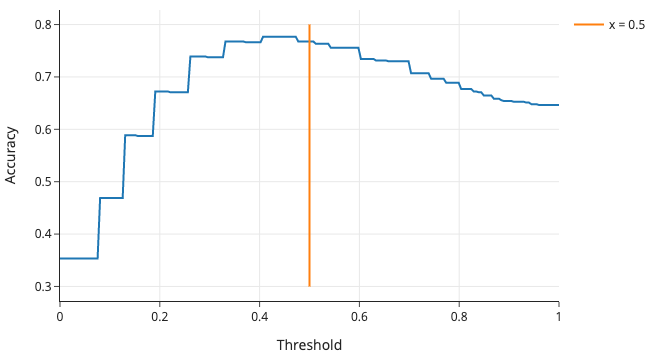

In [8]:
fig = px.line(x=thresholds, y=accs, width=450, height=250)
fig.add_trace(go.Scatter(x=[0.5, 0.5], y=[0.3, 0.8],
                         name='x = 0.5', mode='lines'))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Accuracy")

Notice that the threshold with the highest accuracy isn't exactly at 0.5. In practice we should use cross validation to select the threshold (see {numref}`Chapter %s <ch:risk>`).
The threshold that maximizes accuracy could be a value other than 0.5 for many reasons, but a common one is *class imbalance*, where one category is more frequent than another. Under class imbalance, a fitted model more often classifies a record as belonging to the more frequently observed category. We have seen this phenomenon when fitting the constant model. This explains why accuracy alone is often not how we want to judge a model. Instead, we want to differentiate between the types of correct and incorrect classifications.    

## The Confusion Matrix

A convenient way to visualize errors in a binary classification is to look at the confusion matrix.  The confusion matrix compares what the model predicts with the actual outcomes. There are two types of error in this situation:

1. *False-Positives*: When the actual class is 0 (false) but the model predicts 1 (true).
1. *False-Negatives*: When the actual class is 1 (true) but the model predicts 0 (false).

Ideally, we would like to minimize both kinds of errors, but we often need to manage the balance between these two sources.

:::{note}

The terms "positive" and "negative" come from disease-testing, where is a test indicated the presence of the disease, it was called a positive result. This can be a bit confusing because having a disease doesn't seem like something positive at all. And, $y=1$ denotes the "positive" case. To keep things straight, it's a good idea to confirm your understanding of what $y=1$ stands for in the context of your data.  

:::

Scikit-learn has a function to compute and plot the confusion matrix:

In [9]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y, lr_model.predict(X))
mat

array([[377,  49],
       [104, 129]])

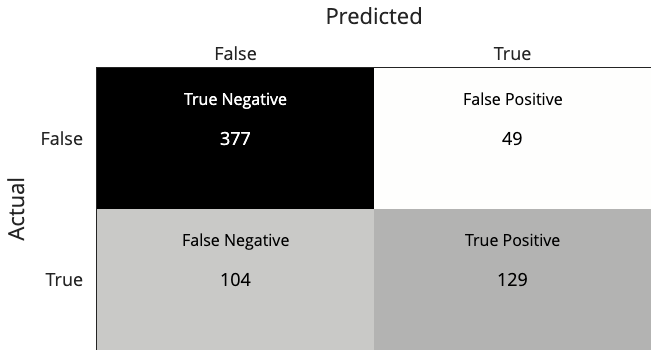

In [28]:
fig = ff.create_annotated_heatmap(z=mat,
                                  x=["False", "True"], y=["False", "True"], 
                                  showscale=False, 
                                 colorscale=px.colors.sequential.gray_r)
fig.update_layout(font=dict(size=18), width=350, height=300)
# Add Labels
fig.add_annotation(x=0,y=0, text="True Negative", 
                   yshift=40, showarrow=False, font=dict(color="white",size=16))
fig.add_annotation(x=1,y=0, text="False Positive", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))
fig.add_annotation(x=0,y=1, text="False Negative", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))
fig.add_annotation(x=1,y=1, text="True Positive", 
                   yshift=40, showarrow=False, font=dict(color="black",size=16))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")

It is usually more informative to compare rates, rather than counts. Next, we describe different rates and when we might prefer to prioritize one of the other.   

## Precision vs Recall

In some settings, there might be a much higher cost to missing positive cases.  For example, if we are building a classifier to identify tumors, 
we want to make sure that we don't miss any malignant tumors. Conversely, we're less concerned about classifying a benign tumor as malignant because a pathologist would still need to take a closer look to verify the malignant classification. In this case, we want to have a high true positive rate among the records that are actually positive. The rate is called *sensitivity*, or *recall*:

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} = \frac{\text{True Positives}}{\text{Actually True}}
$$

Higher recall runs the risk of predicting true on false records (false positives).

On the other hand, when classifying email as spam (positive) or ham (negative), we might be annoyed if an important email gets thrown into our spam folder. In this setting, we want high *precision*, the accuracy of the model for positive predictions:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} = \frac{\text{True Positives}}{\text{Predicted True}}
$$

Higher precision models are often more likely to predict that true observations are negative (higher false negative rate).

A common analysis compares the precision and recall at different thresholds. We compute the precision and recall for our fitted model as the threshold varies:

In [32]:
from sklearn import metrics
precision, recall, threshold = (
    metrics.precision_recall_curve(y, lr_model.predict_proba(X)[:, 1]))

tpr_df = pd.DataFrame({"threshold":threshold, 
                       "precision":precision[:-1], "recall": recall[:-1], })

To see how precision and recall relate, we plot them both against the threshold $ \tau $:

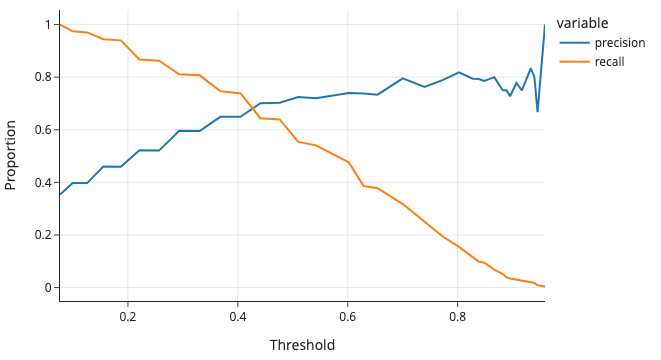

In [47]:
fig = px.line(tpr_df, x='threshold', y=['precision','recall'],
              labels={
                     "threshold": "Threshold",
                     "y": "Proportion"
                 },
             width=550, height=250)
fig.update_yaxes(title="Proportion")
fig

Using precision and recall gives us more control over what kinds of errors matter. For example, let's suppose we want to ensure that at least 75% of the fallen trees are classified as fallen. We can find the threshold where this occurs:

In [60]:
fall75_ind = np.argmin(recall >= 0.75) - 1

fall75_threshold = threshold[fall75_ind]
fall75_precision = precision[fall75_ind]
fall75_recall = recall[fall75_ind]

In [58]:
print(f'Threshold: {fall75_threshold:.2}')
print(f'Precision: {fall75_precision:.2}')
print(f'Recall:    {fall75_recall:.2}')

Threshold: 0.33
Precision: 0.59
Recall:    0.81


We find that about 41% (1 - precision) of the trees that we classify as fallen are actually standing. In addition, we find the fraction of trees below this threshold to be:  

In [61]:
print("Proportion of samples below threshold:", 
      f"{np.mean(lr_model.predict_proba(X)[:,1] < fall75_threshold):0.2f}")

Proportion of samples below threshold: 0.52


So, we have classified 52% of the samples as standing (negative). *Specificity* (also called *true negative rate*) measures the proportion of data belonging to the negative class that the classifier labels as negative:

$$
\text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives} + \text{False Positives}} = \frac{\text{True Negatives}}{\text{Predicted False}}
$$

The specificity for our threshold is: 

In [63]:
act_neg = (y == 0)
true_neg = (lr_model.predict_proba(X)[:,1] < fall75_threshold) & act_neg

In [64]:
print(f"Specificity: {np.sum(true_neg) / np.sum(act_neg):0.2f}")

Specificity: 0.70


In other words, 70% of the trees classified as standing are actually standing.

As we've seen, there are several ways to use the 2 by 2 confusion matrix. Ideally, we want accuracy, precision, and recall to all be high. This happens when the most predictions fall along the diagonal for the table, which also means and we have mostly true negatives and true positives. Unfortunately, in most scenarios our models will have some amount of error. In our example, trees of the same diameter include a mix of fallen and standing so we can't perfectly classify trees based on their diameter. In practice, when data scientists choose a threshold, they need to consider their context to decide whether to prioritize precision, recall, or specificity.